In [1]:
# Copyright 2021 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Scaling Criteo: Training with TensorFlow

## Overview

We observed that TensorFlow training pipelines can be slow as the dataloader is a bottleneck. The native dataloader in TensorFlow randomly sample each item from the dataset, which is very slow. The window dataloader in TensorFlow is not much faster. In our experiments, we are able to speed-up existing TensorFlow pipelines by 9x using a highly optimized dataloader.<br><br>

We have already discussed the NVTabular dataloader for TensorFlow in more detail in our [Getting Started with Movielens notebooks](https://github.com/NVIDIA/NVTabular/tree/main/examples/getting-started-movielens).<br><br>

We will use the same techniques to train a deep learning model for the [Criteo 1TB Click Logs dataset](https://ailab.criteo.com/download-criteo-1tb-click-logs-dataset/).

### Learning objectives

In this notebook, we learn how to:

- Use **NVTabular dataloader** with TensorFlow Keras model

## NVTabular dataloader for TensorFlow

We’ve identified that the dataloader is one bottleneck in deep learning recommender systems when training pipelines with TensorFlow. The dataloader cannot prepare the next batch fast enough and therefore, the GPU is not fully utilized. 

We developed a highly customized tabular dataloader for accelerating existing pipelines in TensorFlow. In our experiments, we see a speed-up by 9x of the same training workflow with NVTabular dataloader. NVTabular dataloader’s features are:

- removing bottleneck of item-by-item dataloading
- enabling larger than memory dataset by streaming from disk
- reading data directly into GPU memory and remove CPU-GPU communication
- preparing batch asynchronously in GPU to avoid CPU-GPU communication
- supporting commonly used .parquet format
- easy integration into existing TensorFlow pipelines by using similar API - works with tf.keras models

More information in our [blogpost](https://medium.com/nvidia-merlin/training-deep-learning-based-recommender-systems-9x-faster-with-tensorflow-cc5a2572ea49).

In [2]:
# External dependencies
import os
import glob

import nvtabular as nvt

We define our base directory, containing the data.

In [3]:
BASE_DIR = os.environ.get("BASE_DIR", "/raid/data/criteo")
input_path = os.path.join(BASE_DIR, "test_dask/output")

### Defining Hyperparameters

First, we define the data schema and differentiate between single-hot and multi-hot categorical features. Note, that we do not have any numerical input features. 

In [4]:
CONTINUOUS_COLUMNS = ["I" + str(x) for x in range(1, 14)]
CATEGORICAL_COLUMNS = ["C" + str(x) for x in range(1, 27)]
LABEL_COLUMNS = ["label"]
COLUMNS = CONTINUOUS_COLUMNS + CATEGORICAL_COLUMNS + LABEL_COLUMNS
BATCH_SIZE = int(os.environ.get("BATCH_SIZE", 64 * 1024))

# Output from ETL-with-NVTabular
TRAIN_PATHS = sorted(glob.glob(os.path.join(input_path, "train", "*.parquet")))
VALID_PATHS = sorted(glob.glob(os.path.join(input_path, "valid", "*.parquet")))
TRAIN_PATHS, VALID_PATHS

(['/raid/data/criteo2/test_dask/output/train/0.5891ce6774804b929d0bcb05f5a2558b.parquet'],
 ['/raid/data/criteo2/test_dask/output/valid/0.606080e99a63402f891540e7c01a2963.parquet'])

In the previous notebook, we used NVTabular for ETL and stored the workflow to disk. We can load the NVTabular workflow to extract important metadata for our training pipeline.

In [5]:
proc = nvt.Workflow.load(os.path.join(input_path, "workflow"))

The embedding table shows the cardinality of each categorical variable along with its associated embedding size. Each entry is of the form `(cardinality, embedding_size)`. We limit the output cardinality to 16.

In [6]:
EMBEDDING_TABLE_SHAPES = nvt.ops.get_embedding_sizes(proc)
for key in EMBEDDING_TABLE_SHAPES.keys():
    EMBEDDING_TABLE_SHAPES[key] = (
        EMBEDDING_TABLE_SHAPES[key][0],
        min(16, EMBEDDING_TABLE_SHAPES[key][1]),
    )
EMBEDDING_TABLE_SHAPES

{'C1': (10000000, 16),
 'C10': (10000000, 16),
 'C11': (707291, 16),
 'C12': (218510, 16),
 'C13': (11, 16),
 'C14': (2209, 16),
 'C15': (9798, 16),
 'C16': (72, 16),
 'C17': (4, 16),
 'C18': (954, 16),
 'C19': (15, 16),
 'C2': (29612, 16),
 'C20': (10000000, 16),
 'C21': (4553157, 16),
 'C22': (10000000, 16),
 'C23': (291641, 16),
 'C24': (10904, 16),
 'C25': (91, 16),
 'C26': (35, 16),
 'C3': (15050, 16),
 'C4': (7190, 16),
 'C5': (19547, 16),
 'C6': (4, 16),
 'C7': (6492, 16),
 'C8': (1317, 16),
 'C9': (63, 16)}

### Initializing NVTabular Dataloader for Tensorflow

We import TensorFlow and some NVTabular TF extensions, such as custom TensorFlow layers supporting multi-hot and the NVTabular TensorFlow data loader.

In [7]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf

# we can control how much memory to give tensorflow with this environment variable
# IMPORTANT: make sure you do this before you initialize TF's runtime, otherwise
# TF will have claimed all free GPU memory
os.environ["TF_MEMORY_ALLOCATION"] = "0.5"  # fraction of free memory
from nvtabular.loader.tensorflow import KerasSequenceLoader, KerasSequenceValidater
from nvtabular.framework_utils.tensorflow import layers

First, we take a look on our data loader and how the data is represented as tensors. The NVTabular data loader are initialized as usually and we specify both single-hot and multi-hot categorical features as cat_names. The data loader will automatically recognize the single/multi-hot columns and represent them accordingly.

In [8]:
train_dataset_tf = KerasSequenceLoader(
    TRAIN_PATHS,
    batch_size=BATCH_SIZE,
    label_names=LABEL_COLUMNS,
    cat_names=CATEGORICAL_COLUMNS,
    cont_names=CONTINUOUS_COLUMNS,
    engine="parquet",
    shuffle=True,
    buffer_size=0.06,
    parts_per_chunk=1,
)

valid_dataset_tf = KerasSequenceLoader(
    VALID_PATHS,
    batch_size=BATCH_SIZE,
    label_names=LABEL_COLUMNS,
    cat_names=CATEGORICAL_COLUMNS,
    cont_names=CONTINUOUS_COLUMNS,
    engine="parquet",
    shuffle=False,
    buffer_size=0.06,
    parts_per_chunk=1,
)

### Defining Neural Network Architecture

We will define a common neural network architecture for tabular data:

* Single-hot categorical features are fed into an Embedding Layer
* Each value of a multi-hot categorical features is fed into an Embedding Layer and the multiple Embedding outputs are combined via averaging
* The output of the Embedding Layers are concatenated
* The concatenated layers are fed through multiple feed-forward layers (Dense Layers with ReLU activations)
* The final output is a single number with sigmoid activation function

First, we will define some dictionary/lists for our network architecture.

In [9]:
inputs = {}  # tf.keras.Input placeholders for each feature to be used
emb_layers = []  # output of all embedding layers, which will be concatenated
num_layers = []  # output of numerical layers

We create `tf.keras.Input` tensors for all input features.

In [10]:
for col in CATEGORICAL_COLUMNS:
    inputs[col] = tf.keras.Input(name=col, dtype=tf.int32, shape=(1,))

for col in CONTINUOUS_COLUMNS:
    inputs[col] = tf.keras.Input(name=col, dtype=tf.float32, shape=(1,))

Next, we initialize Embedding Layers with `tf.feature_column.embedding_column`.

In [11]:
for col in CATEGORICAL_COLUMNS:
    emb_layers.append(
        tf.feature_column.embedding_column(
            tf.feature_column.categorical_column_with_identity(
                col, EMBEDDING_TABLE_SHAPES[col][0]
            ),  # Input dimension (vocab size)
            EMBEDDING_TABLE_SHAPES[col][1],  # Embedding output dimension
        )
    )

We define `tf.feature_columns` for the continuous input features.

In [12]:
for col in CONTINUOUS_COLUMNS:
    num_layers.append(tf.feature_column.numeric_column(col))

NVTabular implemented a custom TensorFlow layer `layers.DenseFeatures`, which takes as an input the different `tf.Keras.Input` and pre-initialized `tf.feature_column` and automatically concatenate them into a flat tensor.

In [13]:
emb_layer = layers.DenseFeatures(emb_layers)
x_emb_output = emb_layer(inputs)
x_emb_output

<KerasTensor: shape=(None, 416) dtype=float32 (created by layer 'dense_features')>

We add multiple Dense Layers. Finally, we initialize the `tf.keras.Model` and add the optimizer.

In [14]:
x = tf.keras.layers.Dense(128, activation="relu")(x_emb_output)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.compile("sgd", "binary_crossentropy")

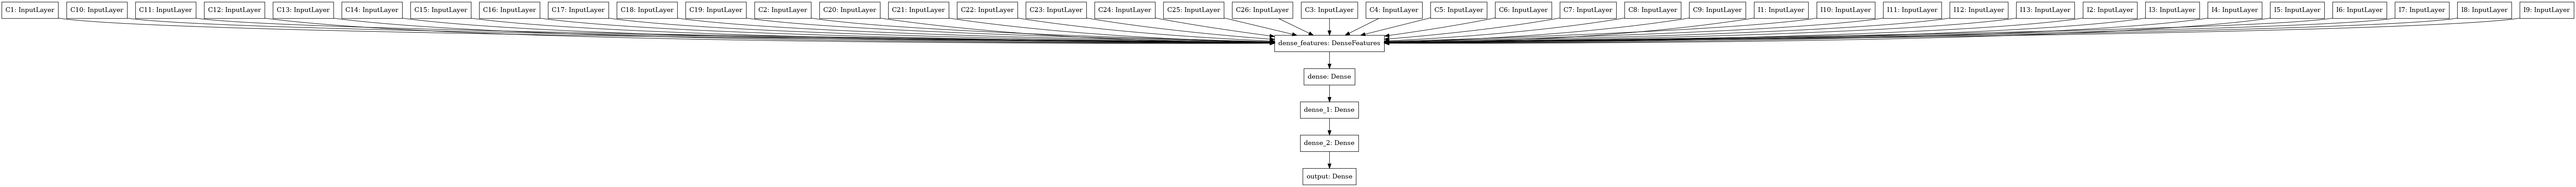

In [15]:
# You need to install the dependencies
tf.keras.utils.plot_model(model)

### Training the deep learning model

We can train our model with `model.fit`. We need to use a Callback to add the validation dataloader.

In [16]:
validation_callback = KerasSequenceValidater(valid_dataset_tf)

history = model.fit(train_dataset_tf, callbacks=[validation_callback], epochs=1)

3046/3046 [==============================] - 103s 32ms/step - loss: 0.1932


We save the trained model.

In [17]:
model.save(os.path.join(input_path, "model.savedmodel"))

INFO:tensorflow:Assets written to: /raid/data/criteo2/test_dask/output/model.savedmodel/assets
